# Udacity Data Scientist Nanodegree - Project 1 (Data Science Blog Post)

## Analyzing Stack Overflow Survey Data

In this project we were using Stack Overflow Survey Data 2019. There are three questions we are going to answer. Explanation and visualization will be presented in order to answer each question. Since we want to analyze only those who are developers, we did filter the survey result so it only contains respondent whose `MainBranch` column is `I am a developer by profession`.

Because the data is quite big and I could not put it in the github repository, you can download the data from [here](https://drive.google.com/file/d/1QOmVDpd8hcVYqqUXDXf68UMDWQZP0wQV/view). We are going to use the `survey_results_public.csv` file.

---

### Questions

1. Which country has the highest job satisfaction for developers ?
2. Is there the difference in job satisfaction between developers whose undergraduate major is IT-related an those who are not ?
3. Do developers who contribute to open source have higher salary than those who are not ?

---

### Data Acquisition & Preparation

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('survey_results_public-Copy1.csv')

In [3]:
# Filter the data so it only contains the survey result by the developer
developer_data = data[data['MainBranch'] == 'I am a developer by profession']

# Fill the N/A values in JobSat column with the mode
developer_data['JobSat'] = developer_data['JobSat'].fillna(developer_data['JobSat'].mode()[0])

# Fill the N/A values in ConvertedComp column with the mean of each country
salary_per_country = developer_data.groupby('Country')['ConvertedComp'].mean()
developer_data['ConvertedComp'] = developer_data.apply(lambda x: salary_per_country[x['Country']] if pd.isnull(x['ConvertedComp']) else x['ConvertedComp'], axis=1)
developer_data = developer_data.dropna(subset=['ConvertedComp'])

# Set the JobSat and OpenSourcerr column into categorical data type so it will be sorted with the right order (ordinal data)
developer_data['JobSat'] = pd.Categorical(developer_data['JobSat'], categories=['Very dissatisfied',
                                                                                'Slightly dissatisfied',
                                                                                'Neither satisfied nor dissatisfied',
                                                                                'Slightly satisfied',
                                                                                'Very satisfied'], ordered=True)

developer_data['OpenSourcer'] = pd.Categorical(developer_data['OpenSourcer'], categories=['Never',
                                                                                'Less than once per year',
                                                                                'Less than once a month but more than once per year',
                                                                                'Once a month or more often'], ordered=True)
print(developer_data['OpenSourcer'].value_counts())
print(developer_data['JobSat'].value_counts())

Never                                                 22365
Less than once per year                               19316
Less than once a month but more than once per year    15983
Once a month or more often                             7996
Name: OpenSourcer, dtype: int64
Slightly satisfied                    23688
Very satisfied                        20261
Slightly dissatisfied                  9554
Neither satisfied nor dissatisfied     7813
Very dissatisfied                      4344
Name: JobSat, dtype: int64


In order to answer the questions, these are the things we did in this data preparation step:
- Filtered the data so it only contains the developer responses.
- Because `JobSat` column is a categorical data, we are going to fill the N/A values with the mode.
- We have the differences in salary range (that really depends on which country the developers live in), so we are going to fill the N/A values in `ConvertedComp` with the average salary of the developer's `Country`. Then we drop the remaining N/A values (19 rows), it happens because there are countries with average `ConvertedComp` = NaN (all of the respondents from that country didn't fill the salary form). 
- Set the `JobSat` and `OpenSourcer` column into categorical data type.

---

### Data Exploration

#### 1. Country with the highest job satisfaction

In [4]:
# Filtered the data so it only contains the survey result from the top 30 country based on the total respondents
top_30_country = list(developer_data['Country'].value_counts().head(30).index)
filtered_developer_data = developer_data[developer_data['Country'].isin(top_30_country)]

# Aggregate the data so we can visualize it later
aggregated_data = filtered_developer_data.groupby(['Country','JobSat'], as_index=False)['Respondent'].count()

# Add column percentage
total_respondents_per_country = filtered_developer_data['Country'].value_counts()

aggregated_data['Respondent Percentage'] = aggregated_data \
                                           .apply(lambda x: x['Respondent'] / total_respondents_per_country[x['Country']], axis=1) \
                                           .round(3)

# Pivot the data
aggregated_data = aggregated_data[['Country', 'JobSat', 'Respondent Percentage']]
pivoted_data = pd.pivot_table(aggregated_data, values='Respondent Percentage', index='Country', columns='JobSat') \
                 .sort_values('Very satisfied', ascending=False)

Because the data contains the respondent from more than 170 countries, <b>we narrow it down to only 30 countries in terms of its total respondents</b>. We did it because we want to gather the data from as much respondents as possible for each country, and each country in the top 30 has the minimum of 400 respondents which we considered enough.

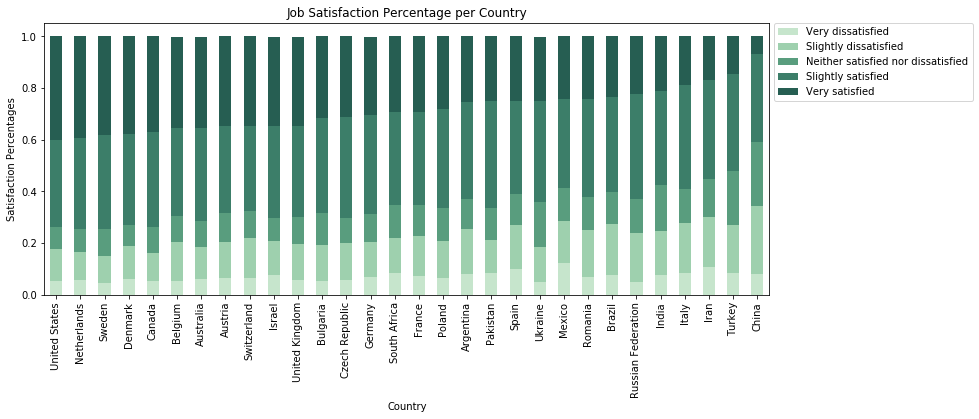

In [5]:
# Visualize the data
pivoted_data.plot(kind='bar', 
                  stacked=True, 
                  colormap=ListedColormap(sns.color_palette("ch:2.5,-.2,dark=.3")),
                  figsize=(13,5))
plt.legend(loc="upper left", bbox_to_anchor=(1,1.02))
plt.ylabel('Satisfaction Percentages')
plt.title('Job Satisfaction Percentage per Country')
plt.show()

The data shows that <b>United States is the best country in terms of job satisfaction of its employees with almost 40% of the developers feel very satisfied</b>, and from the visualization above we know that <b>5 of top 10 countries with the highest job satisfaction are located in Europe</b>.

#### 2. Undergraduate Major with job satisfaction

In [6]:
# Create a new columns to flag each respondent if their major is related or not
def check_major(value):
    '''
    input: the value of each row in the selected column
    output: the mapped value based on the rule we made in this function
    '''

    if value == 'Computer science, computer engineering, or software engineering' \
    or value == 'Information systems, information technology, or system administration' \
    or value == 'Web development or web design':
        return 'IT Related'
    return 'Not IT Related'

developer_data['Major'] = developer_data['UndergradMajor'].apply(check_major)

developer_data['Major'].value_counts(normalize=True)

IT Related        0.708178
Not IT Related    0.291822
Name: Major, dtype: float64

In order to answer this question, we need to cateogrize the `UndergradMajor` column into two types (IT Related and Not IT Related) first. It shows that <b>29% of developers do not have IT-related background (their undergraduate major)</b>.

In [129]:
# Aggregate the data so we know how many respondents in each major (IT related or not IT related)
aggregated_data = developer_data.groupby(['Major','JobSat'], as_index=False)['Respondent'].count()

# Add column percentage
total_respondents_per_major = developer_data['Major'].value_counts()

aggregated_data['Respondent Percentage'] = aggregated_data \
                                           .apply(lambda x: x['Respondent'] / total_respondents_per_major[x['Major']], axis=1) \
                                           .round(4)

# Pivot the data
aggregated_data = aggregated_data[['Major', 'JobSat', 'Respondent Percentage']]
pivoted_data = pd.pivot_table(aggregated_data, values='Respondent Percentage', index='Major', columns='JobSat')

Then we calculate the percentages of each value in `JobSat` to measure the job satisfaction for each major type.

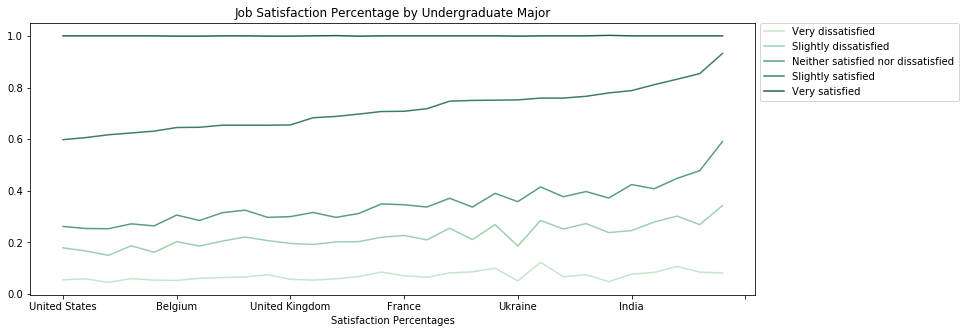

In [8]:
# Visualize the data
pivoted_data.plot(kind='line', 
                  stacked=True, 
                  colormap=ListedColormap(sns.color_palette("ch:2.5,-.2,dark=.3")),
                  figsize=(13,5))
plt.legend(loc="upper left", bbox_to_anchor=(1,1.02))
plt.xlabel('Satisfaction Percentages')
plt.title('Job Satisfaction Percentage by Undergraduate Major')
plt.show()

In [131]:
pivoted_data

JobSat,Very dissatisfied,Slightly dissatisfied,Neither satisfied nor dissatisfied,Slightly satisfied,Very satisfied
Major,,,,,
IT Related,0.0661,0.1493,0.1239,0.3641,0.2966
Not IT Related,0.0664,0.1363,0.1070,0.3527,0.3376


From the visualization and table above, we found that <b>developers whose undergraduate major is not IT-related have slightly better job satisfaction</b> compared those who have IT related background with 34% and 30% respondents feel very satisfied respectively.

#### 3. Compensation and contributing to open source

In [132]:
# Aggregate the data
comp_per_category = developer_data.groupby('OpenSourcer', as_index=False)['ConvertedComp'].mean()

comp_per_category

,OpenSourcer,ConvertedComp
0,Never,117254.369170
1,Less than once per year,120802.882927
2,Less than once a month but more than once per ...,123194.248789
3,Once a month or more often,123881.913894


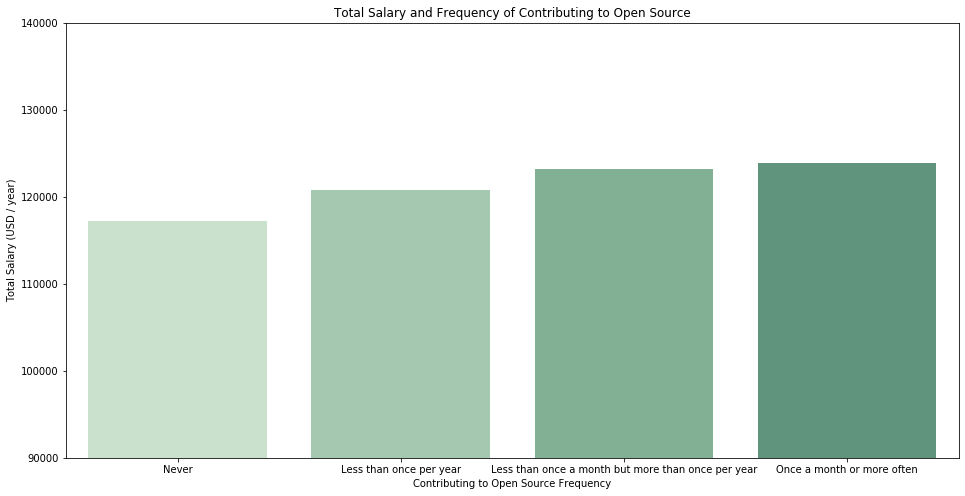

In [133]:
# Visualize the data
plt.figure(figsize=(16, 8))
sns.barplot(data=comp_per_category, x='OpenSourcer', y='ConvertedComp', palette=sns.color_palette("ch:2.5,-.2,dark=.3"))
plt.ylim(90000,140000)
plt.title('Total Salary and Frequency of Contributing to Open Source')
plt.ylabel('Total Salary (USD / year)')
plt.xlabel('Contributing to Open Source Frequency')
plt.show()

We can see from the data that <b>the more frequent the developers contribute to open source, the higher their salary.</b> People who contribute to open source once a month or more have 7% higher salary than those who never contribute.

The correlation between those two variables does not mean if we want the higher salary, we have to start contributing to open source. We need to remember one thing, <b>correlation does not imply causation</b>. One thing that seems reasonable about those correlation are, you need to have some sort of skills if you want to contribute to open source (I did not mean that a newbie in programming could not contribute but we can agree that the more experienced developers must be better at doing that), thus make you a more skilled and better developers, and the more skilled someone, the higher their salary.

---

### Conlusion

In this notebook we did the analysis about developers from Stack Overflow Survey Data 2019, and these are the summary of what we have done.<br>

1. We measure the job satisfaction level for each country and found that <b>United States has the highest job satisfaction level in the world, and 5 of top 10 countries with the highest job satisfaction level are located in Europe</b>.
2. We then looked at their undergraduate major and found that <b>developers whose undergraduate major is not IT-related have slightly better job satisfaction</b>.
3. Finally, we found that <b>developers who contribute more to the open source have the higher salary</b>.